In [1]:
import sys
sys.path.append("../")
import analysis_utils as au
import numpy as np
from astropy.convolution import Gaussian2DKernel, convolve_fft
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
x = np.arange(-1000, 1000, 1)
y = np.arange(-1000, 1000, 1)
xx, yy = np.meshgrid(x, y)
r = np.sqrt(xx**2 + yy**2)

# noise mock data
rand = np.random.default_rng(199716)
data = rand.normal(loc=0.0, scale=1.0, size=(x.size, y.size))
# data = rand.uniform(low=-0.5, high=0.5, size=(x.size, y.size))

# beam convolution
kernel = Gaussian2DKernel(x_stddev=10, y_stddev=10)
data_conv = convolve_fft(data, kernel)
noise = np.std(data_conv)
beam_area = np.pi * au.sigma_to_FWHM(10) ** 2 / (4 * np.log(2))

In [102]:
np.mean(data_conv)

0.00012626972030768243

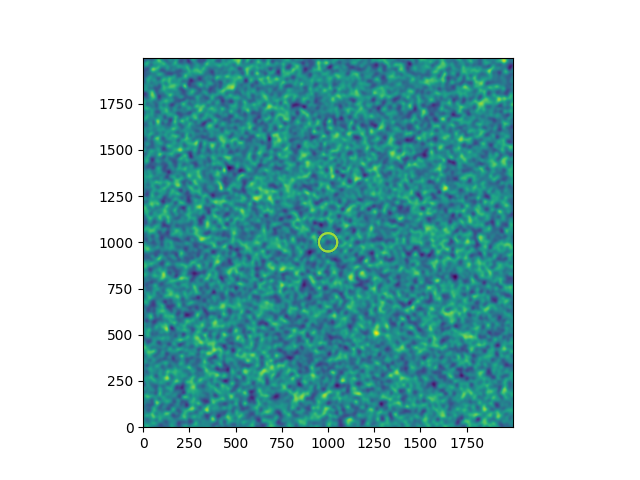

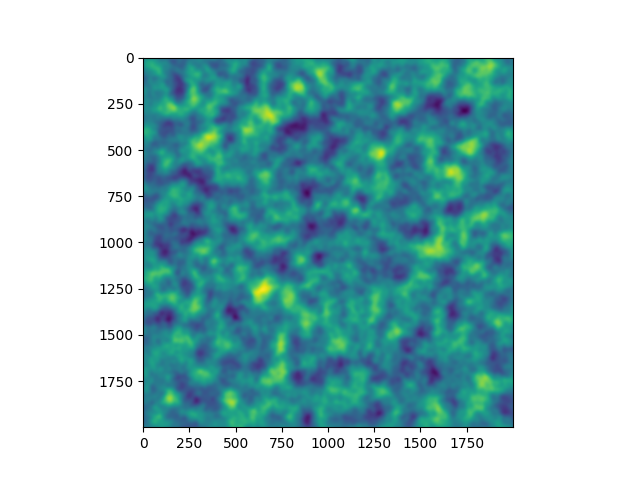

In [93]:
# check plot
plt.figure()
plt.imshow(data_conv, origin="lower")
disk_mask = r <= 50
plt.contour(disk_mask)

plt.figure()
plt.imshow(convolve_fft(data_conv, disk_mask))

In [96]:
np.mean(convolve_fft(data_conv, disk_mask))

0.00035646993366101763

In [3]:
# disk masking convolution
mask_radii = np.arange(1, 150, 5)
# w = np.arange(0.01, 100, 0.1)
noise_disk = []
noise_boxcar = []
expectation_disk = []
expectation_boxcar = []
for rout in mask_radii:
    disk_kernel = r <= rout
    boxcar_kernel = (np.abs(xx) <= rout) & (np.abs(yy) <= rout)
    data_disk = convolve_fft(data_conv, disk_kernel)
    data_boxcar = convolve_fft(data_conv, boxcar_kernel)
    noise_disk.append(np.std(data_disk))
    noise_boxcar.append(np.std(data_boxcar))
    mask_area = np.sum(disk_kernel)
    expectation_disk.append(np.sqrt(2 * beam_area / mask_area))
    mask_area = np.sum(boxcar_kernel)
    expectation_boxcar.append(np.sqrt(2 * beam_area / mask_area))

In [65]:
# analytic
from scipy import special

w = np.sqrt(np.pi * 4 * mask_radii ** 2 / 2 / beam_area)
# w = mask_radii / 10
ratio_boxcar = (np.sqrt(np.pi) / w * special.erf(w) - (1 - np.exp(-w**2)) / w**2)# * 10 / (mask_radii * np.sqrt(np.pi))

w = np.sqrt(np.pi * np.pi * mask_radii ** 2 / 2 / beam_area)
# w = mask_radii / 10 
ratio_disk = np.sqrt(np.pi) / w * special.erf(w) - (1 - np.exp(-w**2)) / w**2
# w = mask_radii / 10
# w = 1/2
# ratio_disk = (- (-np.e**(1/(2/w**2)) + special.iv(0, 1/(2/w**2)) + special.iv(1, 1/(2/w**2))) / (2 * np.e**(1/(2/w**2)))) * 2 * np.sqrt(2) / w

In [66]:
w = mask_radii / 10
f = w ** 2 / 2
A = -(
        -np.e ** f
        + special.iv(0, f)
        + special.iv(1, f)
    ) / (2 * np.e ** f)


ratio_disk_b = np.sqrt(A) * 2 * np.sqrt(2) / w
# ratio_disk =


Text(0.5, 0, 'mask radius [pix]')

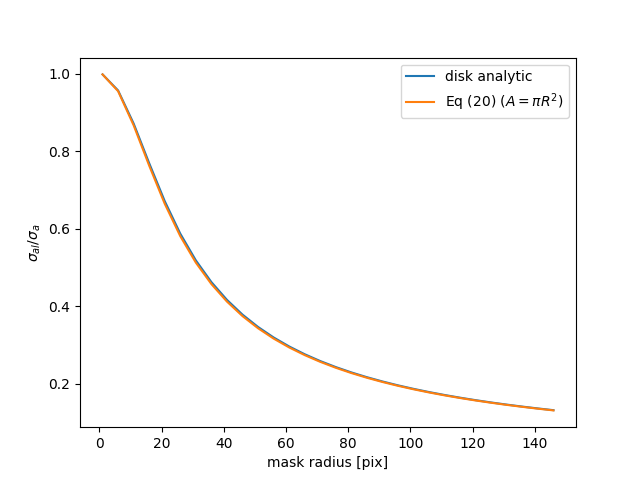

In [67]:
plt.figure()
plt.plot(mask_radii, ratio_disk_b, label="disk analytic")
plt.plot(mask_radii, ratio_disk, label="Eq (20) ($A = \pi R^2$)")
plt.legend()
plt.ylabel(r"$\sigma_{al}/\sigma_{a}$")
plt.xlabel("mask radius [pix]")

Text(0.5, 0, 'mask radius [pix]')

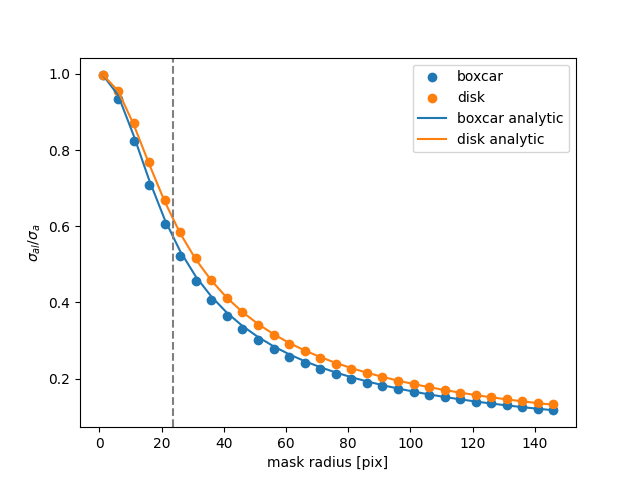

In [68]:
plt.figure()
plt.scatter(mask_radii, np.array(noise_boxcar)/noise, label="boxcar")
plt.scatter(mask_radii, np.array(noise_disk)/noise, label="disk")
# plt.plot(mask_radii, expectation_boxcar, label=r"$\sqrt{2\Omega_\mathrm{beam}/\Omega_\mathrm{mask}}$", color="tab:blue")
# plt.plot(mask_radii, expectation_disk, label=r"$\sqrt{2\Omega_\mathrm{beam}/\Omega_\mathrm{mask}}$", color="tab:orange")
plt.plot(mask_radii, ratio_boxcar, label="boxcar analytic")
plt.plot(mask_radii, ratio_disk, label="disk analytic")
plt.legend()
# plt.yscale("Log")
plt.axvline(x=au.sigma_to_FWHM(10), color="grey", ls="dashed")
plt.ylabel(r"$\sigma_{al}/\sigma_{a}$")
plt.xlabel("mask radius [pix]")

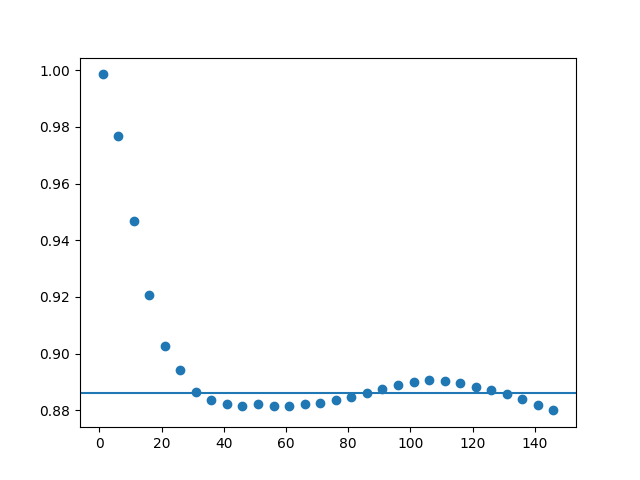

In [64]:
plt.figure()
plt.scatter(mask_radii, np.array(noise_boxcar)/np.array(noise_disk), label="ratio")
plt.axhline(y=np.sqrt(np.pi/4))